# Neural Color Transfer (Multi-Reference Style Transfer)

## Library

In [1]:
#Append 'src' direc to import modules from notebooks directory#
##################################################
#import os,sys
#src_dir=os.path.join(os.getcwd(),os.pardir)
#sys.path.append(src_dir)
#################################################

In [2]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib as plt
import time
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import cv2
from torchvision import transforms
from torchvision.utils import make_grid
from collections import OrderedDict
from PIL import Image,ImageOps
import torch.optim as optim
import scipy
from skimage import color

## Input Source & Reference Image

In [4]:
USE_CUDA = True  # or False if you don't have CUDA
FEATURE_IDS = [1, 6, 11, 20, 29]

imgS_path = './image/3_Source1.jpg'
imgR_path = './image/3_Reference.jpg'

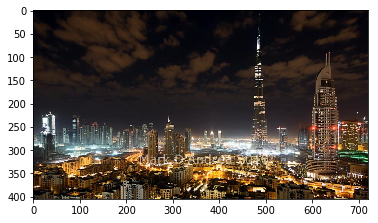

In [5]:
# Checking
origS = Image.open(imgS_path).convert("RGB")
imshow(origS)

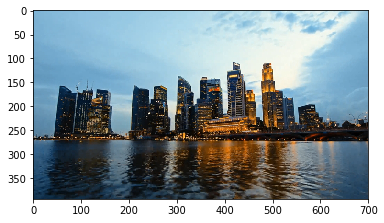

In [6]:
# Checking
origR = Image.open(imgR_path).convert("RGB")
imshow(origR)

## Image Loader

In [11]:
def image_loader(img_path, flip=False):
    img = Image.open(img_path).convert("RGB")
    if flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    img_tensor = data_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def tsshow(img_tensor):
    img_np = img_tensor.squeeze().numpy().transpose(1, 2, 0)
    imshow(img_np)  #, interpolation = 'nearest')

In [12]:
imgS=image_loader(imgS_path, flip=False)
imgR=image_loader(imgR_path, flip=False)

imgS_np = imgS.squeeze().numpy().transpose(1, 2, 0)
imgR_np = imgR.squeeze().numpy().transpose(1, 2, 0)

In [13]:
# Checking
print(imgS.size())  # (1, 3, SHeight, SWidth)
print(imgR.size())  # (1, 3, RHeight, RWidth)
print(imgS.dtype, imgR.dtype, "\n")  # torch.float32

print(imgS_np.shape)  # (SHeight, SWidth, 3)
print(imgR_np.shape, "\n")  # (RHeight, RWidth, 3)

# Verifying normalization
print("Original S's mean:", np.asarray(origS).mean(axis=(0, 1)))
print("Original S's std:", np.asarray(origS).std(axis=(0, 1)))
print("Normalized S's mean:", imgS_np.mean(axis=(0, 1)))
print("Normalized S's std:", imgS_np.std(axis=(0, 1)), "\n")

print("Original R's mean:", np.asarray(origR).mean(axis=(0, 1)))
print("Original R's std:", np.asarray(origR).std(axis=(0, 1)))
print("Normalized R's mean:", imgR_np.mean(axis=(0, 1)))
print("Normalized R's std:", imgR_np.std(axis=(0, 1)))

torch.Size([1, 3, 405, 720])
torch.Size([1, 3, 394, 700])
torch.float32 torch.float32 

(405, 720, 3)
(394, 700, 3) 

Original S's mean: [61.62190329 50.21784294 41.66634088]
Original S's std: [57.8738523  52.01588416 45.43425297]
Normalized S's mean: [-1.0626439 -1.15655   -1.0782337]
Normalized S's std: [0.99107546 0.9106422  0.79188246] 

Original R's mean: [109.97153009 127.81088107 135.57476432]
Original R's std: [67.65980285 78.28225721 87.38713418]
Normalized R's mean: [-0.23466858  0.20187134  0.5585145 ]
Normalized R's std: [1.1586574 1.3704876 1.5230874]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


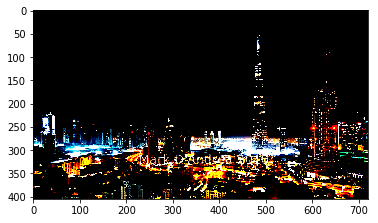

In [14]:
# Checking
tsshow(imgS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


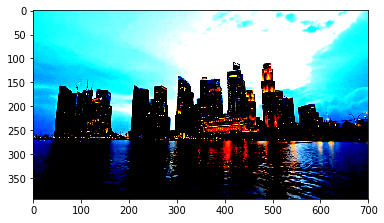

In [15]:
# Checking
tsshow(imgR)

## Process
From S_6 = S_(L+1) to S_1(Final Result)

Feature Domain
    > FeatureExtractor
    > PatchMatch
    > BDS Voting

Image Domain
    > Resolution equal
    > Local Color Transfer

## FeatureExtractor

In [16]:
class FeatureExtractor(nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self, name, layer):
        self.add_module(name, layer)

    def forward(self, x, feature_id):
        for idx, module in enumerate(self._modules):
            x = self._modules[module](x)
            if idx == feature_id:
                return x

In [17]:
vgg_temp = models.vgg19(pretrained=True).features
model = FeatureExtractor()  # The new Feature Extractor module network

conv_counter = 1
relu_counter = 1

block_counter = 1

for i, layer in enumerate(list(vgg_temp)):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_" + str(conv_counter)
        conv_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_" + str(relu_counter)
        relu_counter += 1
        model.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        bn_counter = relu_counter = conv_counter = 1
        block_counter += 1
        model.add_layer(name, layer)  # Is nn.AvgPool2d((2,2)) better than nn.MaxPool2d?

if USE_CUDA:
    model.cuda('cuda:3')

In [18]:
# Checking
print(model)
print([list(model._modules)[idx] for idx in FEATURE_IDS])

FeatureExtractor(
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU(inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU(inplace)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU(inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU(inplace)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU(inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU(inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU(inplace)
  (conv_3_4): Conv2d(256, 256, kernel_size=(

In [24]:
def get_feature(img_tensor, feature_id):
    if USE_CUDA:
        img_tensor = img_tensor.cuda('cuda:3')

    feature = model(img_tensor, feature_id)
    feature = feature.data.squeeze().cpu().numpy().transpose(1, 2, 0)
    return np.array(feature)

def normalize(feature):
    return feature / np.linalg.norm(feature, ord=2, axis=2, keepdims=True)

In [25]:
feat5S = normalize(get_feature(imgS, FEATURE_IDS[4]))
feat5R = normalize(get_feature(imgR, FEATURE_IDS[4]))

In [26]:
# Checking
print(feat5S.shape)
print(feat5R.shape)

(25, 45, 512)
(24, 43, 512)


In [18]:
# (IN PROGRESS)
# EXPERIMENTAL
class DeepDream:
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter, im_path):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        self.image = image_loader(im_path, flip=False)

        if USE_CUDA:
            self.model.cuda('cuda:3')
            self.image = self.image.cuda('cuda:3')

        self.image.requires_grad_()
        # Hook the layers to get result of the convolution
        self.hook_layer()

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Get the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]

        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def dream(self):
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas lower layers need less
        optimizer = optim.SGD([self.image], lr=12, weight_decay=1e-4)
        # optimizer = optim.Adam([self.image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 251):
            optimizer.zero_grad()
            # Assign image to a variable to move forward in the model
            x = self.image
            for index, layer in enumerate(self.model):
                # Forward
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            if i % 10 == 0:
                print("Iteration:", str(i) + "/250", "Loss:", "{0:.2f}".format(loss.data.cpu().numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()

Iteration: 10/250 Loss: -21.25
Iteration: 20/250 Loss: -56.55
Iteration: 30/250 Loss: -85.62
Iteration: 40/250 Loss: -110.38
Iteration: 50/250 Loss: -132.78
Iteration: 60/250 Loss: -153.31
Iteration: 70/250 Loss: -172.35
Iteration: 80/250 Loss: -190.09
Iteration: 90/250 Loss: -206.54
Iteration: 100/250 Loss: -221.93
Iteration: 110/250 Loss: -236.68
Iteration: 120/250 Loss: -250.73
Iteration: 130/250 Loss: -264.05
Iteration: 140/250 Loss: -277.05
Iteration: 150/250 Loss: -289.53
Iteration: 160/250 Loss: -301.58
Iteration: 170/250 Loss: -313.25
Iteration: 180/250 Loss: -324.68
Iteration: 190/250 Loss: -335.95
Iteration: 200/250 Loss: -346.91
Iteration: 210/250 Loss: -357.66
Iteration: 220/250 Loss: -368.27
Iteration: 230/250 Loss: -378.75
Iteration: 240/250 Loss: -389.03


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration: 250/250 Loss: -399.19


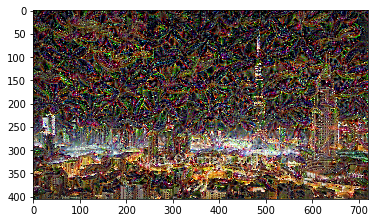

In [19]:
# (IN PROGRESS)
# EXPERIMENTAL
cnn_layer = FEATURE_IDS[4]
filter_pos = 94
dd = DeepDream(vgg_temp, cnn_layer, filter_pos, imgS_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()

dd_image_np = dd.image.detach().squeeze().cpu().numpy().transpose(1, 2, 0)
imshow(dd_image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])

## PatchMatch

In [37]:
class PatchMatch: 
    def __init__(self, a, b, patch_size=3):
        self.a = a
        self.b = b
        self.ah = a.shape[0]
        self.aw = a.shape[1]
        self.bh = b.shape[0]
        self.bw = b.shape[1]
        self.patch_size = patch_size

        self.nnf = np.zeros((self.ah, self.aw, 2)).astype(np.int)  # The NNF
        self.nnd = np.zeros((self.ah, self.aw))  # The NNF distance map
        self.init_nnf()

    def init_nnf(self):
        for ay in range(self.ah):
            for ax in range(self.aw):
                by = np.random.randint(self.bh)
                bx = np.random.randint(self.bw)
                self.nnf[ay, ax] = [by, bx]
                self.nnd[ay, ax] = self.calc_dist(ay, ax, by, bx)

    def calc_dist(self, ay, ax, by, bx):
        """
            Measure distance between 2 patches across all channels
            ay -- y coordinate of a patch in a
            ax -- x coordinate of a patch in a
            by -- y coordinate of a patch in b
            bx -- x coordinate of a patch in b
        """
        dy0 = dx0 = self.patch_size // 2
        dy1 = dx1 = self.patch_size // 2 + 1
        dy0 = min(ay, by, dy0)
        dy1 = min(self.ah - ay, self.bh - by, dy1)
        dx0 = min(ax, bx, dx0)
        dx1 = min(self.aw - ax, self.bw - bx, dx1)

        dist = np.sum(np.square(self.a[ay - dy0:ay + dy1, ax - dx0:ax + dx1] - self.b[by - dy0:by + dy1, bx - dx0:bx + dx1]))
        dist /= ((dy0 + dy1) * (dx0 + dx1))
        return dist

    def improve_guess(self, ay, ax, by, bx, ybest, xbest, dbest):
        d = self.calc_dist(ay, ax, by, bx)
        if d < dbest:
            ybest, xbest, dbest = by, bx, d
        return ybest, xbest, dbest

    def improve_nnf(self, total_iter=5):
        for iter in range(total_iter):
            if iter % 2:
                ystart, yend, ychange = self.ah - 1, -1, -1
                xstart, xend, xchange = self.aw - 1, -1, -1
            else:
                ystart, yend, ychange = 0, self.ah, 1
                xstart, xend, xchange = 0, self.aw, 1

            for ay in range(ystart, yend, ychange):
                for ax in range(xstart, xend, xchange):
                    ybest, xbest = self.nnf[ay, ax]
                    dbest = self.nnd[ay, ax]

                    # Propagation
                    if (ay - ychange) < self.ah and (ay - ychange) >= 0:
                        yp, xp = self.nnf[ay - ychange, ax]
                        yp += ychange
                        if yp < self.bh and yp >= 0:
                            ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)
                    if (ax - xchange) < self.aw and (ax - xchange) >= 0:
                        yp, xp = self.nnf[ay, ax - xchange]
                        xp += xchange
                        if xp < self.bw and xp >= 0:
                            ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)

                    # Random search
                    rand_d = max(self.bh, self.bw)
                    while rand_d >= 1:
                        ymin, ymax = max(ybest - rand_d, 0), min(ybest + rand_d, self.bh)
                        xmin, xmax = max(xbest - rand_d, 0), min(xbest + rand_d, self.bw)
                        yp = np.random.randint(ymin, ymax)
                        xp = np.random.randint(xmin, xmax)
                        ybest, xbest, dbest = self.improve_guess(ay, ax, yp, xp, ybest, xbest, dbest)
                        rand_d = rand_d // 2

                    self.nnf[ay, ax] = [ybest, xbest]
                    self.nnd[ay, ax] = dbest
            print("iteration:", str(iter + 1) + "/" + str(total_iter))

    def solve(self):
        self.improve_nnf(total_iter=5)

In [42]:
map5SR = PatchMatch(feat5S, feat5R) #S -> R
map5RS = PatchMatch(feat5R, feat5S) #R -> S
map5SR.solve()
print()
map5RS.solve()

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5

iteration: 1/5
iteration: 2/5
iteration: 3/5
iteration: 4/5
iteration: 5/5


In [43]:
# Checking
print(map5SR.nnf.shape)
print(map5SR.nnd.shape, "\n")

print(map5RS.nnf.shape)
print(map5RS.nnd.shape)

(25, 45, 2)
(25, 45) 

(24, 43, 2)
(24, 43)


## Image Resizing

In [44]:
def image_to_tensor(img, img_transforms=[]):
    data_transforms = transforms.Compose(img_transforms + [
        transforms.ToTensor(),
    ])
    img_tensor = data_transforms(img)
    return img_tensor

def resize_img(img, size):
    return image_to_tensor(img, [transforms.Resize(size)])

imgS_resized = resize_img(origS, feat5S.shape[:2])
imgR_resized = resize_img(origR, feat5R.shape[:2])

In [45]:
# Checking
print(imgS_resized.size())
print(imgR_resized.size())

torch.Size([3, 25, 45])
torch.Size([3, 24, 43])


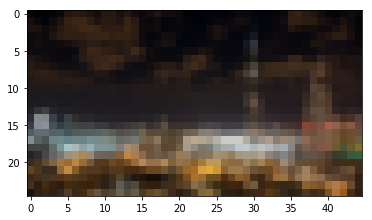

In [46]:
# Checking
tsshow(imgS_resized)

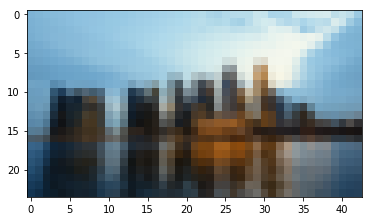

In [47]:
# Checking
tsshow(imgR_resized)

## BDS Voting (Reconstruct) (수정필요)

In [49]:
def bds_vote(snn, rnn, snnd, rnnd, src, patchsize=3):
    """
    Reconstructs an image or feature map by bidirectionaly
    similarity voting
    """

    src_height = src.shape[1]   # C * H * W
    src_width = src.shape[2]
    channels = src.shape[0]
    print("src_height: " + str(src_height))
    print("src_width: " + str(src_width))

    dest_height = snn.shape[1]
    dest_width = snn.shape[2]
    dest = np.zeros((channels, dest_height, dest_width))

    print("dest_height: " + str(dest_height))
    print("dest_width: " + str(dest_width))

    pmax = patchsize // 2

    weights = np.zeros((dest_height, dest_width))
    ws = 1 / (snn.shape[1] * snn.shape[2])  # (dest_height * dest_width)
    wr = 1 / (rnn.shape[1] * rnn.shape[2])  # (src_height * src_width)

    # coherence
    # The S->R forward NNF enforces coherence
    for i in range(dest_height):
        for j in range(dest_width):
            py = snn[0, i, j]
            px = snn[1, i, j]

            for dy in range(-pmax, pmax + 1):
                if i + dy < 0:
                    continue
                if i + dy >= dest_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= src_height:
                    break
                for dx in range(-pmax, pmax + 1):
                    if j + dx < 0:
                        continue
                    if j + dx >= dest_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= src_width:
                        break
                    for ch in range(channels):
                        dest[ch, i + dy, j + dx] += ws * src[ch, py + dy, px + dx]
                    weights[i + dy, j + dx] += ws


    # completeness
    # The R->S backward NNF enforces completeness
    for i in range(src_height):
        for j in range(src_width):
            py = rnn[0, i, j]
            px = rnn[1, i, j]

            for dy in range(-pmax, pmax + 1):
                if i + dy < 0:
                    continue
                if i + dy >= src_height:
                    break
                if py + dy < 0:
                    continue
                if py + dy >= dest_height:
                    break
                for dx in range(-pmax, pmax + 1):
                    if j + dx < 0:
                        continue
                    if j + dx >= src_width:
                        break
                    if px + dx < 0:
                        continue
                    if px + dx >= dest_width:
                        break
                    for ch in range(channels):
                        dest[ch, py + dy, px + dx] += wr * src[ch, i + dy, j + dx]
                    weights[py + dy, px + dx] += wr

    for y in range(dest_height):
        for x in range(dest_width):
            s = 1 if weights[y, x] == 0 else (1 / weights[y, x])
            for ch in range(channels):
                dest[ch, y, x] *= s

    return dest

In [53]:
G = bds_vote(map5SR.nnf.transpose(2, 0, 1), map5RS.nnf.transpose(2, 0, 1), map5SR.nnd, map5RS.nnd, imgR_resized)
print(G)
print(G.shape)

src_height: 24
src_width: 43
dest_height: 25
dest_width: 45
[[[0.71078436 0.62026147 0.56013074 ... 0.16143792 0.20849674 0.30686276]
  [0.81045754 0.74814817 0.64139436 ... 0.22838355 0.23386956 0.26274511]
  [0.67189543 0.65185187 0.63834425 ... 0.2294924  0.23099256 0.20784314]
  ...
  [0.32971357 0.33927878 0.28366014 ... 0.22745098 0.21612201 0.19346405]
  [0.19024834 0.20215342 0.29737717 ... 0.30370371 0.1633987  0.14509805]
  [0.12800305 0.22026547 0.41957251 ... 0.29934642 0.16862746 0.14901961]]

 [[0.85490197 0.79738563 0.75359479 ... 0.17254903 0.19738563 0.27352942]
  [0.90784316 0.8640523  0.7995643  ... 0.25433439 0.25734913 0.31764709]
  [0.71764706 0.71154685 0.74640524 ... 0.27309773 0.28066412 0.32156864]
  ...
  [0.2927232  0.29562071 0.25664489 ... 0.16296297 0.17559913 0.19215687]
  [0.20810201 0.20328776 0.26533576 ... 0.20653595 0.12810458 0.12941177]
  [0.11918792 0.17904156 0.32157828 ... 0.20784315 0.12679739 0.12941177]]

 [[0.91372549 0.8882353  0.8620915  

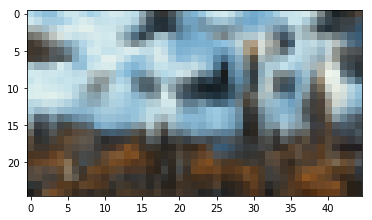

In [55]:
imshow(np.transpose(G,(1,2,0)))

## 오늘은 여기까지

## Affine Transfrom

In [38]:
###example of rgb2lab but can't use in here bacause different initilization process.
origSnp = np.asarray(origS)/255 ##0~255를 0~1로 만든다 rgb2lab엔 range detection이 없어서
origS_lab = color.rgb2lab(origSnp)
origS_lab

array([[[ 68.22041515,   3.09829757,  -7.06738869],
        [ 68.22041515,   3.09829757,  -7.06738869],
        [ 68.22041515,   3.09829757,  -7.06738869],
        ..., 
        [ 71.68514622,   3.08095938,  -2.93812813],
        [ 71.68514622,   3.08095938,  -2.93812813],
        [ 71.31505123,   3.08425348,  -2.9411943 ]],

       [[ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        ..., 
        [ 70.94456415,   3.08756869,  -2.94427955],
        [ 70.57368246,   3.09090524,  -2.9473841 ],
        [ 70.57368246,   3.09090524,  -2.9473841 ]],

       [[ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        [ 67.84661992,   3.10224993,  -7.07511646],
        ..., 
        [ 69.62476451,   4.02949357,  -4.36347497],
        [ 69.62476451,   4.02949357,  -4.36347497],
        [ 69.25249493,   4.03396516,  -4.36813823]],

       ..., 
   

In [39]:
origSnp.shape

(266, 400, 3)

In [40]:
npRss = np.asarray(Rs_S)
npRss = np.transpose(npRss,(2,1,0))
labRss = color.rgb2lab(npRss)
labRss.shape #14 14 3

(14, 14, 3)

In [41]:
npG = np.asarray(G)
npG = np.transpose(npG,(2,1,0))
labG = color.rgb2lab(npG)
labG.shape #14 14 3
labGl,labGa, labGb = labG[: , : ,0],labG[: , : , 1], labG[: , : , 2]
labGl #14 14

array([[ 28.3189197 ,  22.3451206 ,  22.21471056,  36.17647112,
         46.6826316 ,   9.4822914 ,   2.13635527,  10.87685169,
          4.20476523,  53.48240037,  42.78668604,  11.42375244,
          9.95016701,   8.66603833],
       [ 40.19780228,  40.19780228,  53.48240037,  53.48240037,
         42.78668604,  42.78668604,  30.59954942,  17.30280965,
         17.82826658,  10.87685169,   4.20476523,  12.45399308,
         10.4925422 ,  35.17200855],
       [ 38.81321411,  38.81321411,  43.53921885,  43.53921885,
         22.3451206 ,  22.3451206 ,  22.21471056,  15.41548292,
         13.15293419,  11.03201808,   4.93258932,  41.03982463,
         45.78148313,  33.58269694],
       [ 38.81321411,  38.81321411,  43.52335557,  38.74824812,
         22.3451206 ,  22.3451206 ,  22.21471056,  22.21471056,
         17.30280965,  12.79793461,  35.61869147,  13.54728854,
          6.16581553,  35.61869147],
       [ 52.48158147,  52.48158147,  49.86777743,  50.42641869,
         28.92044013

In [42]:
meanGl = np.zeros((12,12))
sumGl =np.zeros((12,12))
stdGl = np.zeros((12,12))

#make patch
#patch -> mean, std
for gy in range (1,12):
    for gx in range (1,12):
        meanGl[gy,gx] = (labGl[gy,gx]+labGl[gy-1,gx]+labGl[gy+1,gx]
                         +labGl[gy,gx-1]+labGl[gy-1,gx-1]+labGl[gy+1,gx-1]
                         +labGl[gy,gx+1]+labGl[gy-1,gx+1]+labGl[gy+1,gx+1])/9
        stdGl[gy,gx] = (labGl[gy,gx]-meanGl[gy,gx]+labGl[gy-1,gx]+labGl[gy+1,gx]
                         +labGl[gy,gx-1]+labGl[gy-1,gx-1]+labGl[gy+1,gx-1]
                         +labGl[gy,gx+1]+labGl[gy-1,gx+1]+labGl[gy+1,gx+1])

meanGl #12 12

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  36.43582254,  39.3100619 ,  40.47209537,
         35.51406963,  26.81990573,  19.23998417,  14.85908061,
         17.13026449,  18.05569741,  21.35920899,  20.34064479],
       [  0.        ,  41.79927065,  43.79323029,  40.42130771,
         34.52485798,  27.77586945,  24.15987788,  19.80510935,
         15.32486866,  14.19409565,  16.27821741,  19.3596659 ],
       [  0.        ,  44.12737458,  44.41691636,  38.13943543,
         31.24786114,  22.961055  ,  20.48580183,  16.32748239,
         13.60787085,  16.66172262,  21.44756734,  24.68845888],
       [  0.        ,  45.04879409,  43.91772929,  37.37834801,
         33.66857913,  25.99332848,  25.41365806,  21.72931801,
         19.21777528,  21.13392184,  25.0658265 ,  25.92830182],
       [  0.        ,  38.65991256,

In [43]:
##in patch, need to calculate a,b from (pixel p and nearby 8pixel = q)
class LocalColorTransfer:
    def __init__(self, source, guide, patchsize=3):
        self.s = source
        self.s_height = self.source.shape[1]    #C * H * W (e.g. 3 * 14* 14)  == [0] * [1] * [2]
        self.s_width = self.source.shape[2]
        self.g = guide
        self.g_height = self.guide.shape[1]
        self.g_width = self.guide.shape[2]
        self.patchsize = patchsize
        self.channels = self.source.shape[0]

        self.sew = self.source.shape[2] - self.patchsize + 1 #number of patch that can be made in width
        self.seh = self.source.shape[1] - self.patchsize + 1 #number of patch that can be made in height
        self.gew = self.guide.shape[2] - self.patchsize + 1
        self.geh = self.guide.shape[1] - self.patchsize + 1
        self.patchlab()
    
    def patchlab(self): ##initialize a and b from source and guidance by lab space using mean and std
        for sy in range (1, self.seh):
            for sx in range (1,self.sew):
            
        

SyntaxError: unexpected EOF while parsing (<ipython-input-43-2491c096927f>, line 23)